In [20]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
df = pd.read_excel('dnalink.xlsx') #판다스이용 csv파일 로딩
df.sort_values(by=['Date'], axis=0, inplace=True)
df.set_index('Date',inplace=True)

In [23]:
df

,Close,Open,High,Low,Volume
Date,,,,,
2020-07-15,6660,7150,7150,6430,475253
2020-07-16,6470,6660,6710,6090,393212
2020-07-17,6250,6460,6460,6200,114927
2020-07-20,6400,6330,6710,6330,328946
2020-07-21,6900,6500,6960,6450,474505
...,...,...,...,...,...
2021-01-04,8850,9690,9690,8790,558156
2021-01-05,8920,8620,9070,8420,456365
2021-01-06,9290,9000,9600,8770,490745


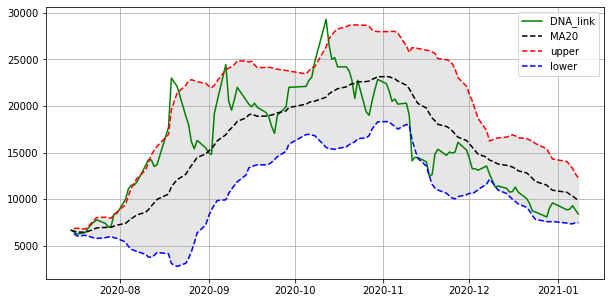

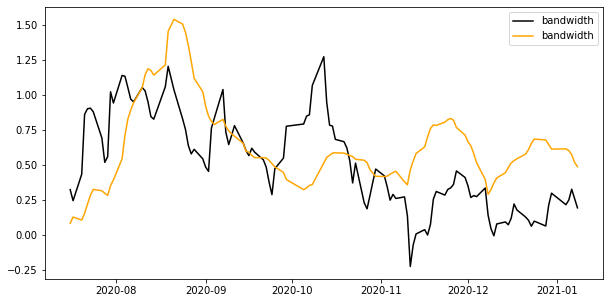

In [24]:
# 볼린저밴드 MA20, stddev, upper, lower
df['MA20'] = df['Close'].rolling(window=20, min_periods=1).mean()
df['stddev'] = df['Close'].rolling(window=20, min_periods=1).std()
df['upper'] = df['MA20'] + (df['stddev'] * 2)
df['lower'] = df['MA20'] - (df['stddev'] * 2)
# plot
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Close'], color='green', label='DNA_link')
plt.plot(df.index, df['MA20'], 'k--', label='MA20')
plt.plot(df.index, df.upper, 'r--', label='upper')
plt.plot(df.index, df.lower, 'b--', label='lower')
plt.fill_between(df.index, df.upper, df.lower, color='0.9')
plt.grid(True)
plt.legend(loc='best')
plt.show()
# percent b + bandwidth
# (%b = ( 종가 - 하단 ) / ( 상단 - 하단 )
# bandwidth = (상단 - 하단) / MA20
df['pb'] = (df.Close - df.lower) / (df.upper - df.lower)
df['bandwidth'] = (df.upper - df.lower) / df.MA20
# plot bandwidth
plt.figure(figsize=(10, 5))
plt.plot(df.index, df.pb, c='black', label='bandwidth')
plt.plot(df.index, df.bandwidth, c='orange', label='bandwidth')
plt.legend(loc='best')
plt.show()

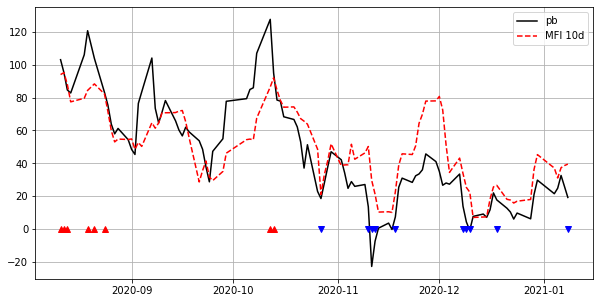

In [25]:
# 추세추종[trend following]
# 1.tp[typical price] = (고가 + 저가 + 종가)/3
df['tp'] = (df.High + df.Low + df.Close) / 3
# i 번째 tp < i+1 번째 tp 인경우 p(positive)mf -> 긍정적인 현금흐름
# i 번째 tp >= i+1 번째 tp 인경우 n(negative)mf -> 부정적인 현금흐름
df['pmf'] = 0
df['nmf'] = 0
for i in range(len(df.Close) - 1):
    if df.tp.values[i] < df.tp.values[i + 1]:
        # 중심가*거래량
        df.pmf.values[i + 1] = df.tp.values[i + 1] * df.Volume.values[i + 1]
        df.nmf.values[i + 1] = 0
    else:
        # df.tp.values[i] >= df.tp.values[i + 1]
        df.nmf.values[i + 1] = df.tp.values[i + 1] * df.Volume.values[i + 1]
        df.pmf.values[i + 1] = 0
# MFR(money flow ratio) : 10일 동안의 pmf의 합 / 10일 동안의 nmf의 합
df['mfr'] = df.pmf.rolling(window=10).sum() / df.nmf.rolling(window=10).sum()
# MFI10 : 10일 동안의 현금 흐름 100 - (100 / ( 1 + mfr ))
df['mfi10'] = 100 - (100 / (1 + df.mfr))
# 20일(window size)이전 데이터 정제
df = df[19:]
# plot [ %b, mfi 10 ] figsize = 10, 5

plt.figure(figsize=(10, 5))
plt.plot(df.index, df.pb * 100, c='black', label='pb')
plt.plot(df.index, df.mfi10, 'r--', label='MFI 10d')
plt.yticks([-20, 0, 20, 40, 60, 80, 100, 120])
# plot [ 추세추종 매매 시기 (매수) pb > 0.8, mfi > 80 (매도) pb < 0.2, mfi < 20
for i in range(len(df.Close)):
    if df.pb.values[i] > 0.8 and df.mfi10.values[i] > 80:
        plt.plot(df.index.values[i], 0, 'r^')
    elif df.pb.values[i] < 0.2 and df.mfi10.values[i] > 20:
        plt.plot(df.index.values[i], 0, 'bv')
plt.legend(loc='best')
plt.grid(True)
plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


            Close   Open   High  ...      mfi10            ii         iip21
Date                             ...                                       
2020-08-11  14250  13050  14700  ...  93.936649  9.841844e+08           NaN
2020-08-12  14200  14500  14800  ...  95.127290  6.873555e+07           NaN
2020-08-13  13500  14500  14500  ...  87.960695 -6.344988e+08           NaN
2020-08-14  13700  13050  14550  ...  77.363605  2.520159e+09           NaN
2020-08-18  17700  14200  17800  ...  79.541200  1.089545e+10           NaN
...           ...    ...    ...  ...        ...           ...           ...
2021-01-04   8850   9690   9690  ...  37.148848 -4.358680e+08 -10111.672783
2021-01-05   8920   8620   9070  ...  31.104702  1.593041e+08  -5179.978788
2021-01-06   9290   9000   9600  ...  37.350560  1.026081e+08  -5124.855899
2021-01-07   8830   9250   9280  ...  38.640659 -8.048207e+07  -6836.239697
2021-01-08   8390   8900   8900  ...  39.542728 -1.889493e+08 -10510.517899

[100 rows x

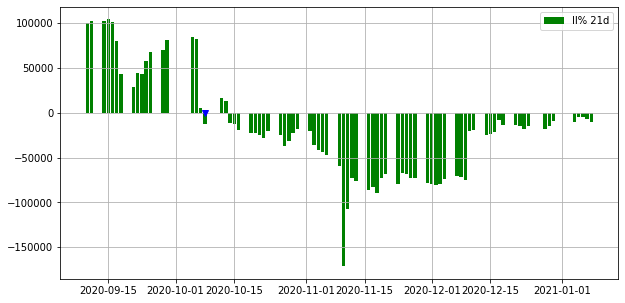

In [27]:
# 일중강도[intraday intensity]: 종가의 위치를 토대로 주식 종목의 자금흐름
# II = ( 2 * 종가 - 고가 - 저가 / 고가 - 저가 ) * 거래량
df['ii'] = (2 * df['Close'] - df['High'] - df['Low'] / df['High'] - df['Low']) * df['Volume']
# II%[intraday intensity %]: 거래량으로 II를 표준화 (21일) = 일중강도의 21일합 / 거래량의 21일 합 * 100
df['iip21'] = df.ii.rolling(window=21).sum() / df.Volume.rolling(window=21).sum() * 100
print(df)
# plot [ 추세추종 매매 시기 (매수) pb <0.05  iip21>0, (매도) pb >0.95  iip21<0
plt.figure(figsize=(10, 5))
plt.bar(df.index, df['iip21'], color='g', label='II% 21d')
for i in range(len(df.Close)):
    if df.pb.values[i] < 0.05 and df.iip21.values[i] > 0:
        plt.plot(df.index.values[i], 0, 'r^')
    elif df.pb.values[i] > 0.95 and df.iip21.values[i] < 0:
        plt.plot(df.index.values[i], 0, 'bv')
plt.legend(loc='best')
plt.grid(True)
plt.show()

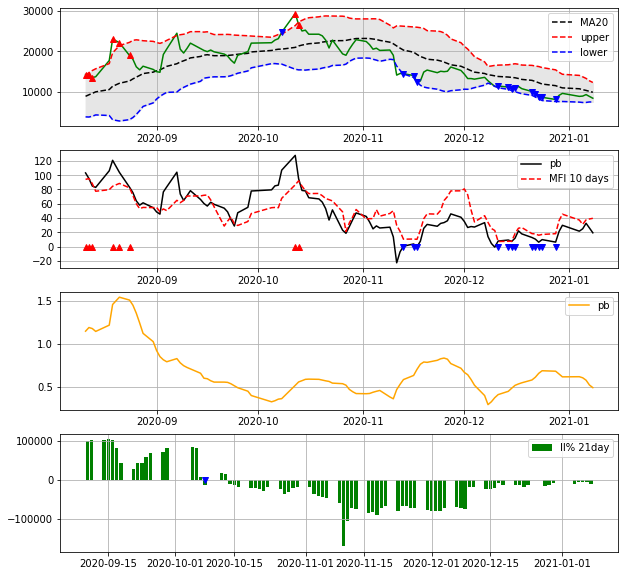

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(411)
plt.plot(df.index, df.MA20, 'k--', label='MA20')
plt.plot(df.index, df.Close, c='green')
plt.plot(df.index, df.upper, 'r--', label='upper')
plt.plot(df.index, df.lower, 'b--', label='lower')
plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')
for i in range(len(df.Close)):
    if df.pb.values[i] > 0.8 and df.mfi10.values[i] > 80:
        plt.plot(df.index.values[i], df.Close.values[i], 'r^')
    elif df.pb.values[i] < 0.2 and df.mfi10.values[i] < 20:
        plt.plot(df.index.values[i], df.Close.values[i], 'bv')
for i in range(len(df.Close)):
    if df.pb.values[i] < 0.05 and df.iip21.values[i] > 0:
        plt.plot(df.index.values[i], df.Close.values[i], 'r^')
    elif df.pb.values[i] > 0.95 and df.iip21.values[i] < 0:
        plt.plot(df.index.values[i], df.Close.values[i], 'bv')

plt.legend(loc='best')
plt.grid(True)
plt.subplot(412)
plt.plot(df.index, df.pb * 100, c='black', label='pb')
plt.plot(df.index, df.mfi10, 'r--', label='MFI 10 days')
plt.yticks([-20, 0, 20, 40, 60, 80, 100, 120])
for i in range(len(df.Close)):
    if df.pb.values[i] > 0.8 and df.mfi10.values[i] > 80:
        plt.plot(df.index.values[i], 0, 'r^')
    elif df.pb.values[i] < 0.2 and df.mfi10.values[i] < 20:
        plt.plot(df.index.values[i], 0, 'bv')

plt.grid(True)
plt.legend(loc='best')
plt.subplot(413)
plt.plot(df.index, df.bandwidth, c='orange', label='pb')
plt.grid(True)
plt.legend(loc='best')
plt.subplot(414)
plt.bar(df.index, df['iip21'], color='g', label='II% 21day')
for i in range(len(df.Close)):
    if df.pb.values[i] < 0.05 and df.iip21.values[i] > 0:
        plt.plot(df.index.values[i], 0, 'r^')
    elif df.pb.values[i] > 0.95 and df.iip21.values[i] < 0:
        plt.plot(df.index.values[i], 0, 'bv')
plt.grid(True)
plt.legend(loc='best')
plt.show()
